In [1]:
import asyncio
import time
import seaborn as sns

from pymodbus import FramerType
from pymodbus.client import AsyncModbusSerialClient, ModbusSerialClient
from pymodbus.payload import BinaryPayloadBuilder
from pymodbus.constants import Endian
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

### Import Optimizer

In [2]:

solver = "appsi_highs"

import pyomo.environ as pyo

SOLVER = pyo.SolverFactory(solver)

assert SOLVER.available(), f"Solver {solver} is not available."

## Scheduler for reducing Harmonic Distortion

- PV 시스템은 예상치 못한 효과(손실, 과열, 공진 등)를 유발하는 고조파 주파수를 생성한다.
- 고조파의 영향을 줄이려면 PV 시스템을 정격 전력 조건에 가깝게 운영해야한다.
- 또한 전력 시스템을 효율적이고 안정적으로 작동하려면 전력 및 발전 균형을 충족해야 한다.
- 본 과제는 PV를 정격 전력에 가깝게 작동시키고 시스템의 전기 수요를 충족시키는 전력을 생성하는 스케쥴링 기술을 개발하는 것이다.
- 이 연구에서는 고조파를 줄이고 시스템 수요에 맞추기 위한 가장 간단한 목적 함수를 정의하여 스케줄링을 수행한다.
- 스케줄링 결과는 Modbus RTU 통신을 통해 각 PV에 전달된다.  

$\text{Objective Function}$
$$ Min \sum_{i}^{n}{\text{Harmonic cost}_i} $$
- $ \text{Harmonic cost}_i = \text{rated power}_i - \text{output power}_i$
-  Where $i$ represents the $ith$ PV system.

$\text{Constraints}$
$$ 0 \leq P_i \leq R_i \\ D_t \geq \sum{G_{i,t}} \\ \sum{G_{i,t}} = 0 \quad if \quad F_i = 0 $$
- Where $P_i$ is the power of $PV_i$, $R_i$ is the rated power of $PV_i$,
- $D_t$ is forecasted system demand, and $G_{i, t}$ is scheduled power of $PV_i$ at time $t$

### 예시 태양광 데이터
- 총 5개의 PV가 존재하며 각 PV의 정격용량은 50, 30, 20, 40, 60 kW이다.

In [3]:
PVs = pd.DataFrame({"PV1": 50, "PV2": 30, "PV3": 20, "PV4": 40, "PV5": 60}, index=[0]) # Values means the rated power of PV.
PVs

,PV1,PV2,PV3,PV4,PV5
0,50,30,20,40,60


### Algorithms

1) 하모닉 감소를 위한 스케줄링을 위해 우선 수용가의 에너지 사용량과 수용가에 공급될 태양광 발전소의 생산량을 예측한다.
    - 여기서에서는 문제를 간단히 하기 위해서 샘플데이터를 사용하여 구성하지만, 기본적으로는 하루 전 예측을 수행하는 형태로 예측 모델이 동작한다.
2) 하모닉 스케줄러는 발전량, 사용량 예측 데이터와, 각 PV의 정격용량을 입력으로 받아, 예측 시간 대별로 각 PV의 최적 출력을 생성한다.

In [4]:
# Sample Data Set
# Assuming the demand and power is forecasted values.
data = pd.DataFrame({"demand": [80, 85, 90, 95, 100, 105, 100, 175, 130, 130, 140, 120, 110, 105, 110, 175, 155, 125, 165, 145, 180, 185, 190, 195],
                     "power": [0, 0, 0, 0, 0, 0, 100, 160, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160, 165, 0, 0, 0, 0]})
data.index = pd.date_range(start="2024-01-01", periods=len(data), freq="h")
data.head(10)

,demand,power
2024-01-01 00:00:00,80,0
2024-01-01 01:00:00,85,0
2024-01-01 02:00:00,90,0
2024-01-01 03:00:00,95,0
2024-01-01 04:00:00,100,0
2024-01-01 05:00:00,105,0
2024-01-01 06:00:00,100,100
2024-01-01 07:00:00,175,160
2024-01-01 08:00:00,130,110
2024-01-01 09:00:00,130,115


In [5]:
data['balance'] = data['demand'] - data['power']
data

,demand,power,balance
2024-01-01 00:00:00,80,0,80
2024-01-01 01:00:00,85,0,85
2024-01-01 02:00:00,90,0,90
2024-01-01 03:00:00,95,0,95
2024-01-01 04:00:00,100,0,100
2024-01-01 05:00:00,105,0,105
2024-01-01 06:00:00,100,100,0
2024-01-01 07:00:00,175,160,15
2024-01-01 08:00:00,130,110,20
2024-01-01 09:00:00,130,115,15


In [6]:
# Define Optimizer

class HarmonicScheduler(pyo.ConcreteModel):
    def __init__(self, demand, generation, plants, solver="appsi_highs"):
      super().__init__("HarmonicScheduler")
      self.demand = demand
      self.generation = generation
      self.plants = plants

      self.solver = pyo.SolverFactory(solver)

      self.solved = False
    def build_model(self):
      model = self.model()
      model.T = pyo.Set(initialize=range(24)) # Timeslots for 24 hours
      model.PV = pyo.Set(initialize=self.plants.columns) # PV index
      
      # Define PV output (Decision variables) with bounds [0, rated power]
      def pv_output_bounds(model, t, pv):
          return (0, self.plants.loc[0, pv])  # Rated power as upper bound
        
      model.output = pyo.Var(model.T, model.PV, domain=pyo.NonNegativeReals, bounds=pv_output_bounds)
      # define harmonic cost
      def harmonic_cost(model):
        return pyo.quicksum(
            (self.plants.loc[0, pv] - model.output[t, pv]) for t in model.T for pv in model.PV)

      # Define Objective function
      model.objective = pyo.Objective(expr=harmonic_cost, sense=pyo.minimize)

      # Define Constraints
      def power_limit_rule(model, t):
        # if generation is 0 -> PV's output 0
        # else match the generation
        return sum(model.output[t, pv] for pv in model.PV) <= self.generation.iloc[t] * (self.generation.iloc[t] > 0)

      def demand_satisfaction_rule(model, t):
        return self.demand.iloc[t] >= sum(model.output[t, pv] for pv in model.PV)

      model.power_limit = pyo.Constraint(model.T, rule=power_limit_rule)
      model.demand_satisfaction = pyo.Constraint(model.T, rule=demand_satisfaction_rule)

    def solve(self):

      self.build_model()
      self.solver.solve(self)
      self.solved = True

    def report_solution(self):
        if not self.solved:
            self.solve()
        
        # Output schedule
        schedule = []
        for t in self.T:
            for pv in self.PV:
                schedule.append((t, pv, pyo.value(self.output[t, pv])))
        
        # Convert schedule to DataFrame
        schedule_df = pd.DataFrame(schedule, columns=["Time Slot", "PV", "Output"])
        self.schedule_df_pivot = schedule_df.pivot(index="PV", columns="Time Slot", values="Output")
        self.schedule_df = schedule_df
        print(schedule_df)

    def plot_heatmap(self, title="PV Output Schedule by Time Slot"):
        plt.figure(figsize=(15, 8))
        
        # Plotting heatmap with seaborn
        sns.heatmap(
            self.schedule_df_pivot,
            annot=True,
            fmt=".2f",
            cmap="YlGnBu",
            linewidths=0.5,
            cbar=True,
            annot_kws={"size": 8, "color": "black", "weight": "bold"}
        )
        
        plt.title(title)
        plt.xlabel("Time Slot")
        plt.ylabel("PV System")
        plt.show()
        
    def plot_bar_chart(self, title="PV Scheduling by Time Slot"):
        fig, axes = plt.subplots(nrows=6, ncols=4, figsize=(20, 20), sharey=True)
        axes = axes.flatten()
        colors = plt.cm.tab20.colors

        for t in range(24):
            ax = axes[t]
            time_slot_data = self.schedule_df[self.schedule_df["Time Slot"] == t]
            ax.bar(time_slot_data["PV"], time_slot_data["Output"], color=colors[:len(self.plants.columns)])
            ax.set_title(f"Time Slot {t}")
            ax.set_ylim(0, max(self.schedule_df["Output"]) * 1.1)
            for i, row in time_slot_data.iterrows():
                ax.text(row["PV"], row["Output"] / 2, f'{row["Output"]:.2f}', ha='center', va='center', color='white')

        fig.suptitle(title)
        plt.tight_layout()
        plt.subplots_adjust(top=0.95)
        plt.show()


     Time Slot   PV  Output
0            0  PV1    -0.0
1            0  PV2     0.0
2            0  PV3     0.0
3            0  PV4     0.0
4            0  PV5     0.0
..         ...  ...     ...
115         23  PV1    -0.0
116         23  PV2     0.0
117         23  PV3     0.0
118         23  PV4     0.0
119         23  PV5     0.0

[120 rows x 3 columns]


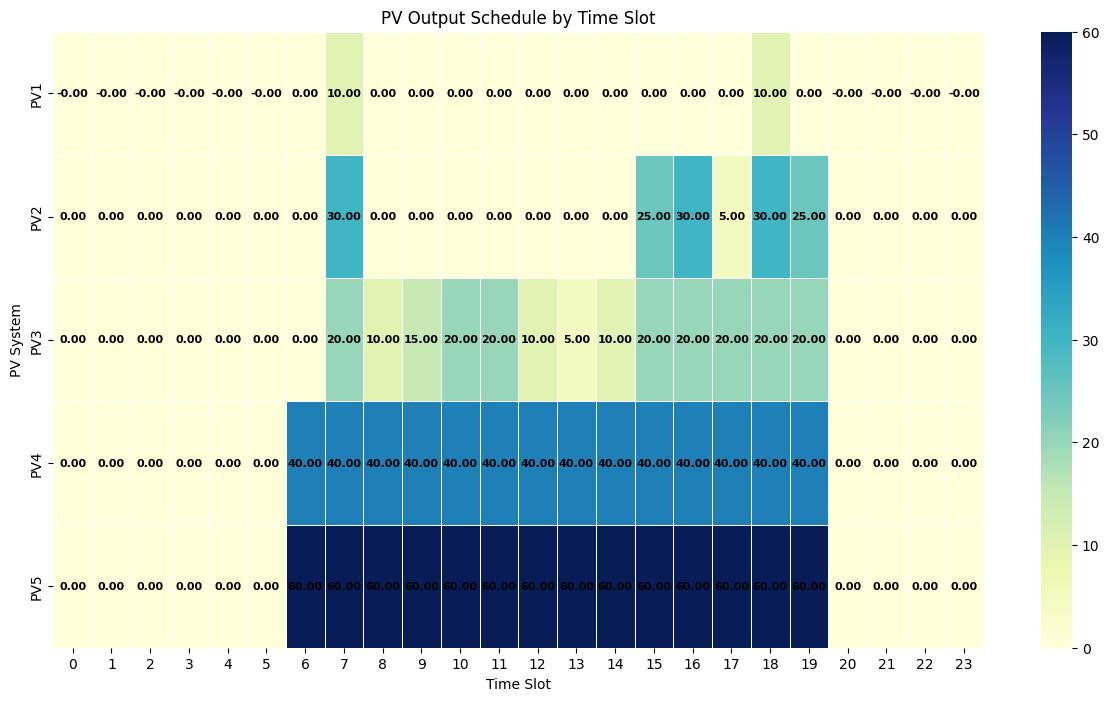

In [7]:
m = HarmonicScheduler(data["demand"], data["power"], PVs)
m.report_solution()
m.plot_heatmap()

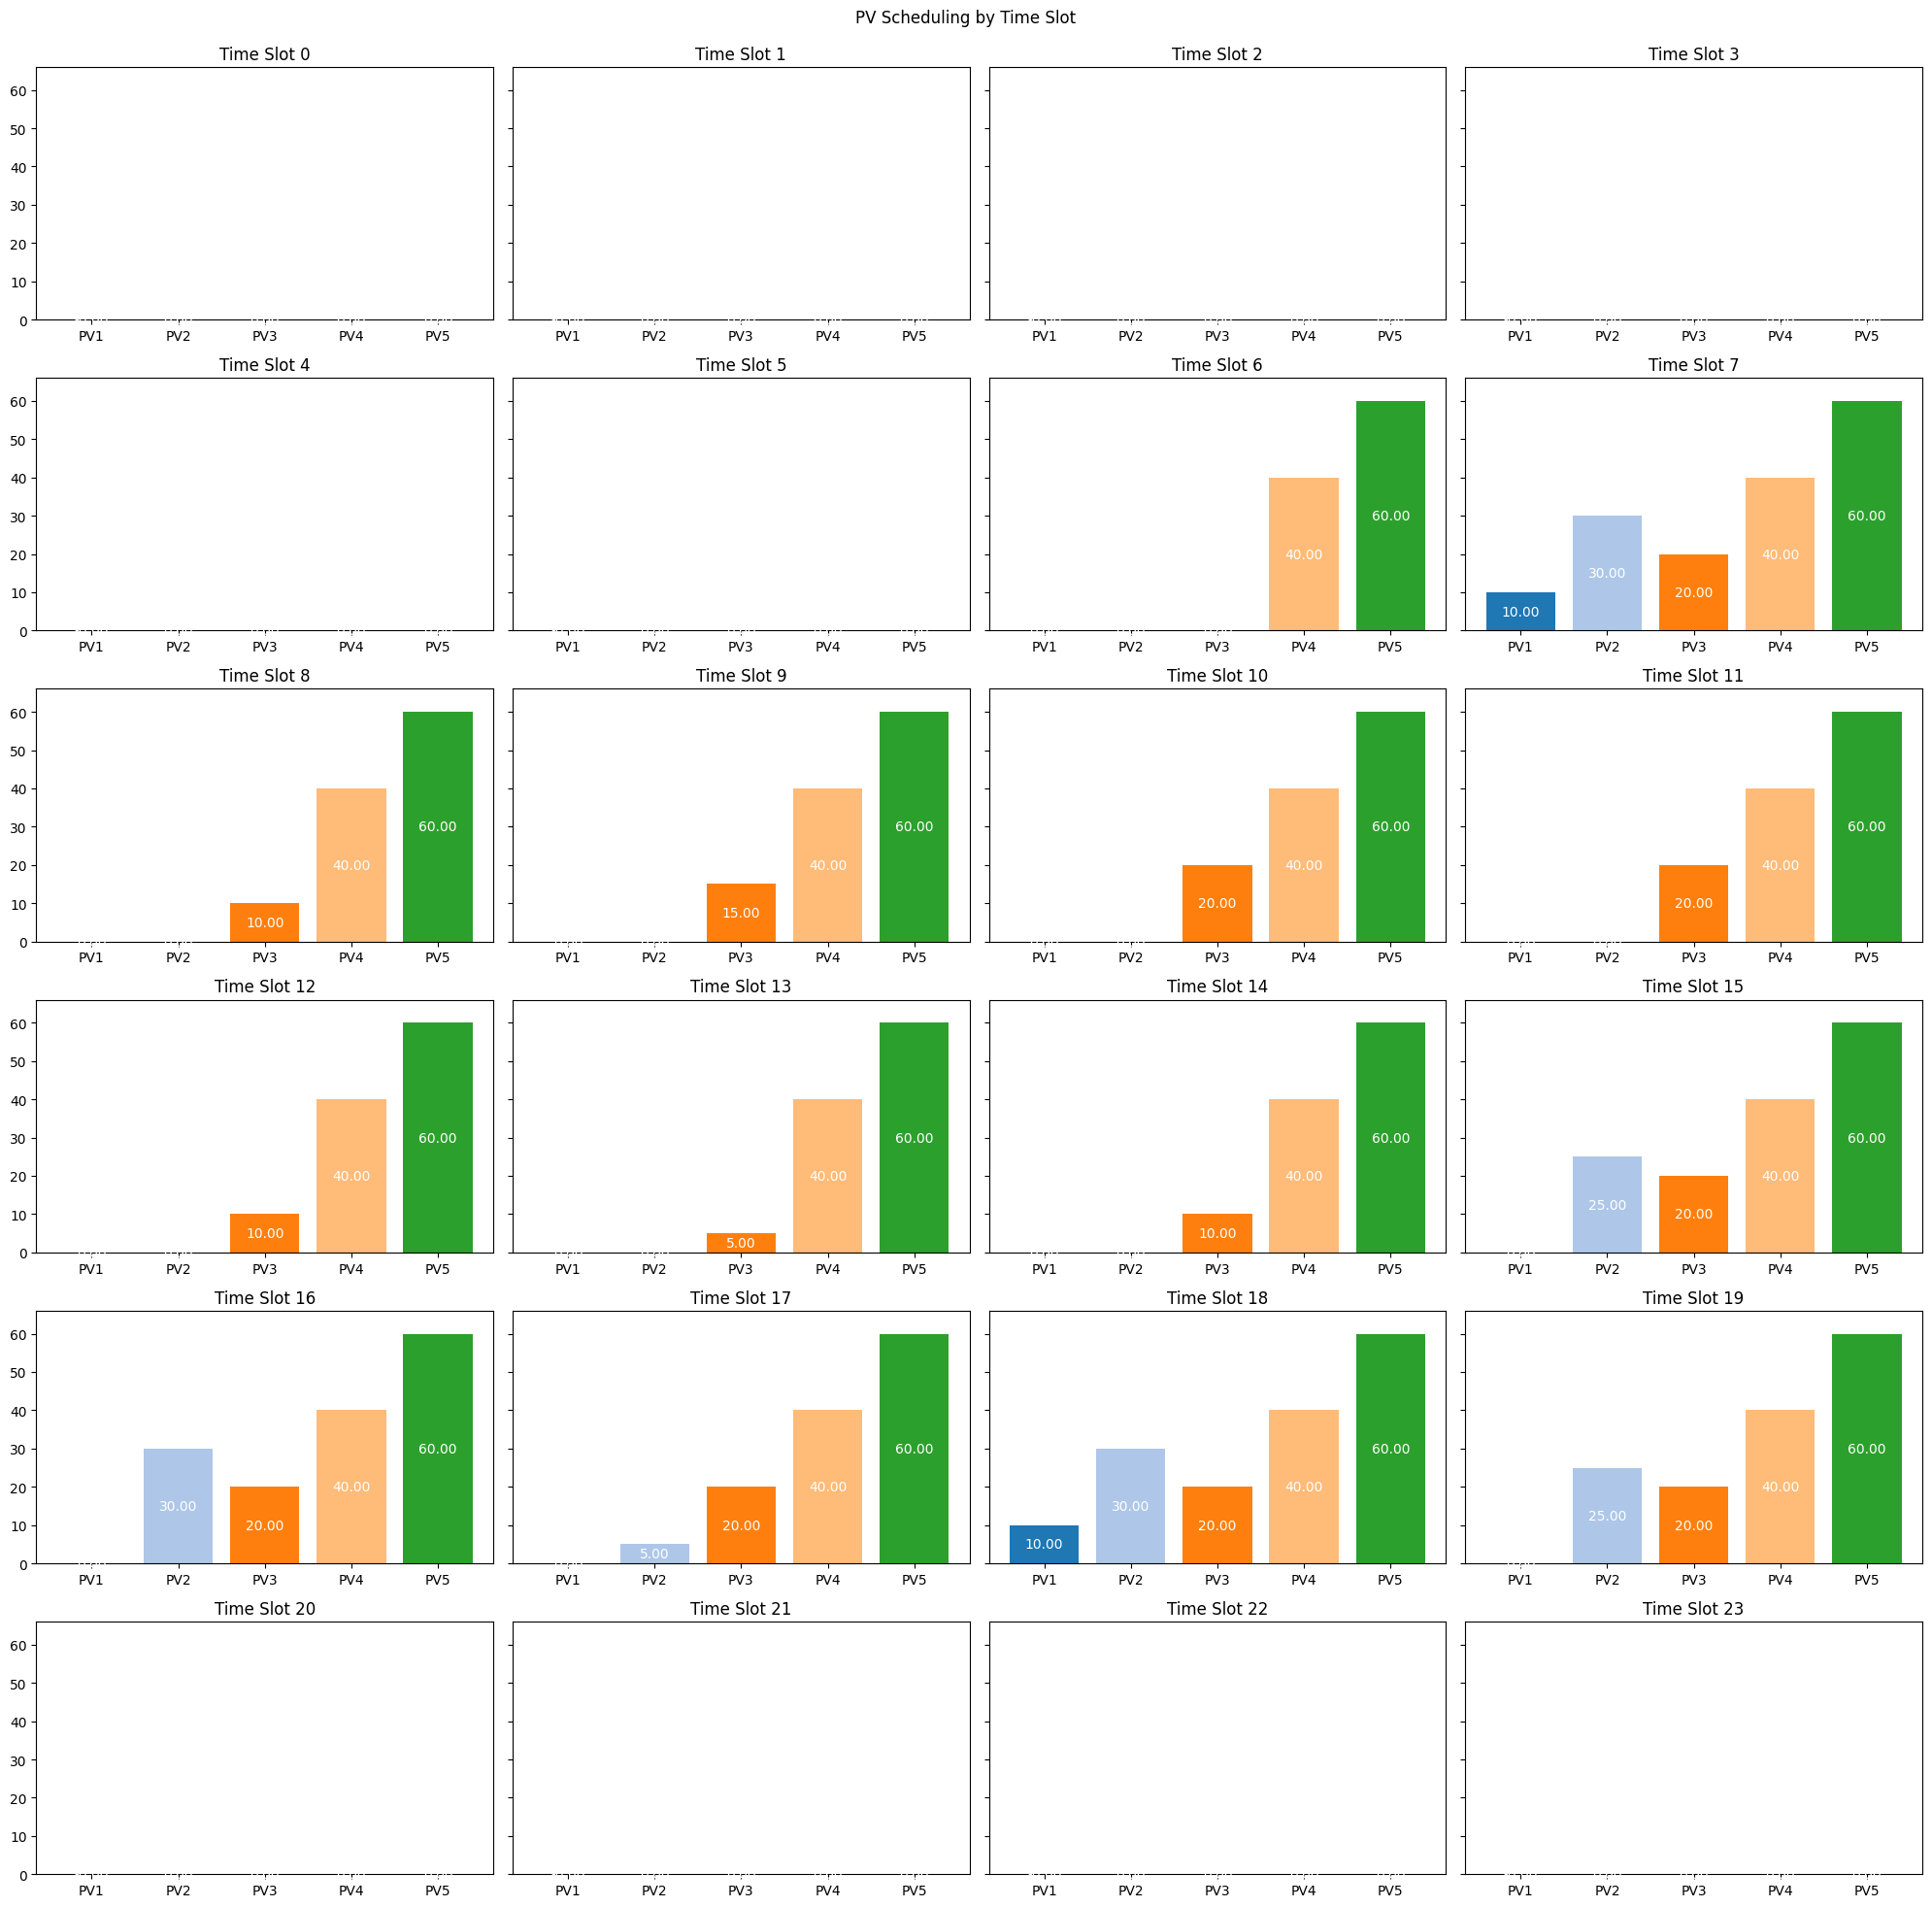

In [8]:
m.plot_bar_chart()

In [9]:
harmonic_schedules = m.schedule_df_pivot.copy()

In [10]:
harmonic_schedules

Time Slot,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
PV,,,,,,,,,,,,,,,,,,,,,
PV1,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,0.0,10.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,-0.0,-0.0,-0.0,-0.0
PV2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,...,0.0,25.0,30.0,5.0,30.0,25.0,0.0,0.0,0.0,0.0
PV3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.0,10.0,15.0,...,10.0,20.0,20.0,20.0,20.0,20.0,0.0,0.0,0.0,0.0
PV4,0.0,0.0,0.0,0.0,0.0,0.0,40.0,40.0,40.0,40.0,...,40.0,40.0,40.0,40.0,40.0,40.0,0.0,0.0,0.0,0.0
PV5,0.0,0.0,0.0,0.0,0.0,0.0,60.0,60.0,60.0,60.0,...,60.0,60.0,60.0,60.0,60.0,60.0,0.0,0.0,0.0,0.0


### Modbus Serial Commucation

- PV3가 모드버스 Serial로 연결되어있다고 가정
- PV3의 Holding Register의 첫 번째 주소에 매 시간 출력값을 전달

In [21]:
def write_float_payload(value):
    builder = BinaryPayloadBuilder(byteorder = Endian.BIG, wordorder=Endian.LITTLE)
    builder.add_32bit_float(value)
    registers = builder.to_registers()
    # print("Writing Registers:")
    # print(registers)
    # print("\n")
    payload = builder.build()
    return registers

In [13]:
print("---- Testing Sunc Client -----")
client = ModbusSerialClient(port="COM3",
                            framer=FramerType.RTU,
                            baudrate=9600)
client.connect()
assert client.connected
print("---- Sucessfully Connected to Modbus Slave")

---- Testing Sunc Client -----
---- Sucessfully Connected to Modbus Slave


In [15]:
PV3_schedules = harmonic_schedules.loc["PV3"]

In [16]:
address = 0 # modbus holding reseter address number
slave = 1 # modbus device id 

In [22]:
for timeslot, s in enumerate(PV3_schedules):
    schedule_value_payload_ = write_float_payload(s)
    # We can write registers
    rr = client.write_registers(address, schedule_value_payload_, slave=slave)
    print(f"Schedule Value is {timeslot}:{s}\n")
    assert not rr.isError()
    
    time.sleep(1)

Schedule Value is 0:0.0

Schedule Value is 1:0.0

Schedule Value is 2:0.0

Schedule Value is 3:0.0

Schedule Value is 4:0.0

Schedule Value is 5:0.0

Schedule Value is 6:0.0

Schedule Value is 7:20.0

Schedule Value is 8:10.0

Schedule Value is 9:15.0

Schedule Value is 10:20.0

Schedule Value is 11:20.0

Schedule Value is 12:10.0

Schedule Value is 13:5.0

Schedule Value is 14:10.0

Schedule Value is 15:20.0

Schedule Value is 16:20.0

Schedule Value is 17:20.0

Schedule Value is 18:20.0

Schedule Value is 19:20.0

Schedule Value is 20:0.0

Schedule Value is 21:0.0

Schedule Value is 22:0.0

Schedule Value is 23:0.0



In [23]:
client.close()

In [ ]:
rr = client.read_input_registers(address=0)
rr.registers

True

True